# Assignment 3 - CS3920

In [1]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

import numpy as np

- Global constants

In [2]:
CV: int = 3
RANDOM_STATE: int = 3103

# Useful Functions

## Convert Dictionary to String

- Takes a dictionary and creates a nice string representation 
- Each key and value are printed with consistent spacing between them

In [3]:
def dictionary_to_string(dictionary: dict) -> str:
	"""Creates a formatted string from a dictionary.

	Args:
		dictionary (dict): dictionary to be formatted

	Returns:
		str: formatted string
	"""	
	# Get the keys and values from the dictionary
	keys: list[str] = list(dictionary.keys())
	values: list[float, dict] = list(dictionary.values())

	# Get the column widths
	column_widths: list[int] = [
		max([len(str(key)), len(str(value))])
		for key, value in zip(keys, values)
	]

	# Create the formatted rows
	formatted_rows: list[str] = []
	for key, value in zip(keys, values):
		# Create a list of formatted column values
		formatted_columns: list[str] = [
			f"{key:{column_widths[0]}}\t {value:{column_widths[1]}}"
		]
		# Join the formatted columns into a single string
		formatted_row: str = " | ".join(formatted_columns)
		formatted_rows.append(formatted_row)

	# Join the formatted rows into a single string
	formatted_table = "\n".join(formatted_rows)
	return formatted_table		

# Loading Datasets

**Question 1**

## Loading Wine Dataset

In [4]:
wine: np.ndarray = load_wine()
X_wine: np.ndarray = wine.data
y_wine: np.ndarray = wine.target

## Loading USPS Dataset

In [5]:
DATA_SPLIT: int = 10 # percentage of data to be used 

In [6]:
zip_train: np.ndarray = np.genfromtxt('zip.train', delimiter=' ')
zip_train = zip_train[::DATA_SPLIT]

zip_test: np.ndarray = np.genfromtxt('zip.test', delimiter=' ')
zip_test = zip_test[::DATA_SPLIT]

zip_data: np.ndarray = np.concatenate((zip_train, zip_test), axis=0)
zip_data = zip_data[::DATA_SPLIT]

X_zip: np.ndarray = zip_data[:, 1:]
y_zip: np.ndarray = zip_data[:, 0]

In [7]:
del zip_train, zip_test

# Splitting Datasets 

**Question 2**

- This functions splits the dataset into training set and test set for each matrix of features `X` and labels  `y`
- It takes the features `X` and labels `y` and returns the split data

In [8]:
def split(X: np.ndarray, y: np.ndarray) -> tuple[np.ndarray[float]]:
	"""Splits the dataset into training and testing sets.

	Args:
		X (np.ndarray): matrix of features
		y (np.ndarray): labels 

	Returns:
		tuple[np.ndarray[float]]: X and y training and testing sets (4 in total)
	"""	
	return train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
	

## Splitting Wine Dataset

In [9]:
X_wine_train, X_wine_test, y_wine_train, y_wine_test = split(X_wine, y_wine)

## Splitting USPS Dataset

In [10]:
X_zip_train, X_zip_test, y_zip_train, y_zip_test = split(X_zip, y_zip)

# Cross Validation

- Performs cross-validation on a dataset for some defined model

In [11]:
class Cross_Validation:
	"""Class for performing cross validation on a dataset."""
	def __init__ (self, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, model: BaseEstimator):
		self.X_train = X_train
		self.y_train = y_train
		self.X_test = X_test
		self.y_test = y_test
		self.model: BaseEstimator = model
		self.model.fit(self.X_train, self.y_train)

	def scores_list(self) -> float:
		"""Computes a list of the scores of the model.

		Returns:
			float: list of the scores of the model
		"""		
		return cross_val_score(self.model, self.X_train, self.y_train, cv=CV)

	@property
	def score(self) -> float:
		"""Computes the score of the model.

		Returns:
			float: score of the model
		"""		
		scores: np.ndarray = cross_val_score(self.model, self.X_train, self.y_train, cv=CV)
		return (self.scores_list()).mean()

	@property
	def error_rate(self) -> float:
		"""Computes the error rate of the model.

		Returns:
			float: error rate of the model
		"""		
		return (1 - self.score)

	@property
	def test_score(self) -> float:
		"""Computes the accuracy of the model against the test set.

		Returns:
			float: accuracy of the model against the test set
		"""		
		return self.model.score(self.X_test, self.y_test)

	@property
	def test_error_rate(self) -> float:
		"""Computes the error rate of the model against the test set.

		Returns:
			float: error rate of the model against the test set
		"""		
		return (1 - self.test_score)

	def __str__(self) -> str:
		"""Returns a formatted string of the model's scores.
		- Score
		- Error Rate
		- Test Score
		- Test Error Rate

		Returns:
			str: string of the model's scores
		"""		
		data: dict = {
			"Score": self.score,
			"Error Rate": self.error_rate,
			"Test Score": self.test_score,
			"Test Error Rate": self.test_error_rate
		}
		return dictionary_to_string(data)	

**Question 3 and 4**

3. `Score` = Estimation of accuracy parameter
4. `Test Error Rate` = Test error rate of the SVM

## Cross Validate Wine

In [12]:
wine_svm_cross_validation: Cross_Validation = Cross_Validation(X_wine_train, y_wine_train, X_wine_test, y_wine_test, SVC())
print(wine_svm_cross_validation)

Score             	 0.6533101045296168
Error Rate        	 0.3466898954703832
Test Score        	 0.7222222222222222
Test Error Rate   	 0.2777777777777778


## Cross Validate USPS

In [13]:
zip_svm_cross_validation: Cross_Validation = Cross_Validation(X_zip_train, y_zip_train, X_zip_test, y_zip_test, SVC())
print(zip_svm_cross_validation)

Score            	 0.660894660894661
Error Rate       	 0.339105339105339
Test Score       	 0.5517241379310345
Test Error Rate  	 0.4482758620689655


# Pipeline

## Dictionary of Hyperparameters

- Dictionary containing a grid of hyperparameters to be used in a grid search.
- The grid contains two hyperparameters: 
  - `C` (`svc__C`) - determines the strength of regularization, or the penalty applied to the model for making incorrect predictions
    - Larger gamma value means that the model is more non-linear, resulting in a more complex and potentially overfitting model
    - Smaller gamma value means that the model is more linear, resulting in a simpler and potentially underfitting model
  - `gamma` (`svc__gamma`) - determines the strength of the non-linearity of the model
    - Larger gamma value means that the model is more non-linear, resulting in a more complex and potentially overfitting model
    - Smaller gamma value means that the model is more linear, resulting in a simpler and potentially underfitting model

In [14]:
param_grid_svm: dict[str, list[float]] = {
	'svc__C': [0.001, 0.01, 0.1, 1, 10, 100], 
	'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}

- Creates a pipeline with Support Vector Correlation (SVC) and some specified scaler (normalizer)
- It takes the training and test data
- Uses Grid Search and Cross-Validation to tune parameters `C` and `gamma`

## Algorithms

### Pipeline of Scalers & Support Vector Correlation with Grid Search

- Creates a model that uses a support vector machine (SVM) classifier with a scaler and performs a grid search
- Uses a pipeline to chain the scaler and the `SVM` classifier
- There are several methods:
  - `best_score` - Computes the score of the predictions made on the test set
    - Can be used to compare the performance of different models or to choose the final model to use for making predictions on new data
  - `best_params` - Identifies the set of hyperparameters that produce the best performance.
    - Can be used to choose the final model to use for making predictions on new data
  - `test_score` - Computes the score of the predictions made on the test set
    - It applies the trained model to the test data and returns a score that indicates how well the model is able to make predictions on the test data
    - Can then be used to choose the final model to use for making predictions on new data
  - `error_rate` - Computes the error rate of the predictions made on the test set
    - $1-score$
    - Hence the points about `test_score` still apply

In [15]:
class Super_Pipeline:
	"""Creates a model that uses a support vector machine (SVM) classifier with a scaler and performs a grid search. 
	Uses a pipeline to chain the scaler and the `SVM` classifier.
	"""	
	def __init__ (self, param_grid: dict[str, list[float]], scaler: BaseEstimator, X_train: np.ndarray[float], y_train: np.ndarray[float], X_test: np.ndarray[float], y_test: np.ndarray[float], model: BaseEstimator):	
		self.pipeline: Pipeline = make_pipeline(scaler(), model)
		self.grid: GridSearchCV = GridSearchCV(self.pipeline, param_grid, cv=CV)
		self.grid.fit(X_train, y_train)
		self.X_train: np.ndarray[float] = X_train
		self.y_train: np.ndarray[float] = y_train
		self.X_test: np.ndarray[float] = X_test
		self.y_test: np.ndarray[float] = y_test
		
	@property
	def best_score(self) -> float:
		"""Computes the score that was obtained using the best set of hyperparameters. 

		Returns:
			float: best score
		"""		
		return self.grid.best_score_

	@property
	def best_params(self) -> dict[str, float]:
		"""Identifies the set of hyperparameters that produce the best performance. 

		Returns:
			dict[str, float]: best parameters
		"""		
		return self.grid.best_params_

	@property
	def test_score(self) -> float:
		"""Computes the score of the predictions made on the test set.


		Returns:
			float: score of the predictions made on the test set
		"""		
		return self.grid.score(self.X_test, self.y_test)

	@property
	def error_rate(self) -> float:
		"""Computes the error rate of the predictions made on the test set.

		Returns:
			float: error rate of the predictions made on the test set
		"""		
		return (1 - self.best_score)

	def __str__(self) -> str:
		"""Returns a string representation of the object.
		- Best Cross-Validation Score
		- Best Parameters
		- Test Set Score
		- Test Set Error Rate

		Returns:
			str: string representation of the object
		"""	
		data: dict = {
			"Best Cross-Validation Score": f"{self.best_score}",
			"Best Parameters": f"{self.best_params}",
			"Test Set Score": f"{self.test_score}",
			"Test Set Error Rate": f"{self.error_rate}"
		}
		return dictionary_to_string(data)

### Drawing Graphs for Comparisons

- Takes multiple pipelines which have multiple scalers 
- Compares:
  - Cross-Validation Accuracy
  - Test Set Error Rate
  - Best Parameter C
  - Best Parameter Gamma

In [16]:
class Graph_Comparisons:
	def __init__ (self, super_pipes: dict[str, Super_Pipeline], best_params: dict[str, float]):
		self.super_pipes: dict[str, Super_Pipeline] = super_pipes
		self.best_params: dict[str, float] = best_params

	def cross_validation_score(self, lower_bound: float, upper_bound: float) -> None:
		"""Compares the cross-validation scores of the models.
		Prints the scores in a table and displays a bar graph.

		Args:
			lower_bound (float): lower bound of the y-axis
			upper_bound (float): upper bound of the y-axis
		"""		
		scores: dict = {key: pipe.best_score for key, pipe in self.super_pipes.items()}
		print(dictionary_to_string(scores))

		plt.bar(self.super_pipes.keys(), [pipe.best_score for pipe in self.super_pipes.values()])
		plt.ylabel("Cross-Validation Accuracy")
		plt.xlabel("Scaler")
		plt.title("Cross-Validation Accuracy by Scaler")
		plt.ylim(lower_bound, upper_bound)
		plt.show()

	def test_score(self, lower_bound: float, upper_bound: float) -> None:
		"""Compares the test set scores of the models.
		Prints the scores in a table and displays a bar graph.

		Args:
			lower_bound (float): lower bound of the y-axis
			upper_bound (float): upper bound of the y-axis
		"""		
		error_rates: dict[str, float] = {key: pipe.error_rate for key, pipe in self.super_pipes.items()}
		print(dictionary_to_string(error_rates))

		plt.bar(error_rates.keys(), error_rates.values())
		plt.ylabel("Test Set Error Rate")
		plt.xlabel("Scaler")
		plt.title("Test Set Error Rate by Scaler")
		plt.ylim(lower_bound, upper_bound)
		plt.show()

	def best_parameter_C(self) -> None:
		"""Compares the best parameter C of the models.
		Prints the best parameter C in a table and displays a bar graph.
		"""		
		best_C: dict[str, float] = {key: pipe.best_params['svc__C'] for key, pipe in self.super_pipes.items()}
		print(dictionary_to_string(best_C))

		plt.bar(self.super_pipes.keys(), [pipe.best_params['svc__C'] for pipe in self.super_pipes.values()])
		plt.bar(self.super_pipes.keys(), [pipe.best_params['svc__C'] for pipe in self.super_pipes.values()])
		plt.ylabel("Best Parameter C")
		plt.xlabel("Scaler")
		plt.title("Best Parameter C")
		plt.show()

	def best_parameter_gamma(self) -> None:
		"""Compares the best parameter gamma of the models.
		Prints the best parameter gamma in a table and displays a bar graph.
		"""		
		best_gamma: dict[str, float] = {key: pipe.best_params['svc__gamma'] for key, pipe in self.super_pipes.items()}
		print(dictionary_to_string(best_gamma))

		plt.loglog(self.super_pipes.keys(), [pipe.best_params['svc__gamma'] for pipe in self.super_pipes.values()])
		plt.ylabel("Best Parameter Gamma")
		plt.xlabel("Scaler")
		plt.xscale("log")
		plt.title("Best Parameter Gamma")
		plt.show()

**Question 5 and 6**

## Wine Dataset

### MinMax Scaler

In [17]:
wine_svm_super_pipe_minmax: Super_Pipeline = Super_Pipeline(param_grid_svm, MinMaxScaler, X_wine_train, y_wine_train, X_wine_test, y_wine_test, SVC())
print(wine_svm_super_pipe_minmax)

Best Cross-Validation Score	 0.991869918699187                
Best Parameters            	 {'svc__C': 10, 'svc__gamma': 0.1}
Test Set Score             	 0.9814814814814815               
Test Set Error Rate        	 0.008130081300813052             


### Standard Scaler

In [18]:
wine_svm_super_pipe_standard: Super_Pipeline = Super_Pipeline(param_grid_svm, StandardScaler, X_wine_train, y_wine_train, X_wine_test, y_wine_test, SVC())
print(wine_svm_super_pipe_standard)

Best Cross-Validation Score	 0.983933410762679                   
Best Parameters            	 {'svc__C': 100, 'svc__gamma': 0.001}
Test Set Score             	 0.9814814814814815                  
Test Set Error Rate        	 0.01606658923732096                 


### Normalizer

In [19]:
wine_svm_super_pipe_normalizer: Super_Pipeline = Super_Pipeline(param_grid_svm, Normalizer, X_wine_train, y_wine_train, X_wine_test, y_wine_test, SVC())
print(wine_svm_super_pipe_normalizer)

Best Cross-Validation Score	 0.927022841656988                 
Best Parameters            	 {'svc__C': 100, 'svc__gamma': 100}
Test Set Score             	 0.9629629629629629                
Test Set Error Rate        	 0.072977158343012                 


### Robust Scaler

In [20]:
wine_svm_super_pipe_robust: Super_Pipeline = Super_Pipeline(param_grid_svm, RobustScaler, X_wine_train, y_wine_train, X_wine_test, y_wine_test, SVC())
print(wine_svm_super_pipe_robust)

Best Cross-Validation Score	 0.983739837398374                 
Best Parameters            	 {'svc__C': 10, 'svc__gamma': 0.01}
Test Set Score             	 0.9814814814814815                
Test Set Error Rate        	 0.016260162601625994              


### Comparison

In [21]:
wine_super_pipes_svm: dict[str, Super_Pipeline] = {
	"MinMaxScaler": wine_svm_super_pipe_minmax,
	"StandardScaler": wine_svm_super_pipe_standard,
	"Normalizer": wine_svm_super_pipe_normalizer,
	"RobustScaler": wine_svm_super_pipe_robust
}
wine_graph: Graph_Comparisons = Graph_Comparisons(wine_super_pipes_svm, param_grid_svm)

#### Best Cross-Validation Score

MinMaxScaler     	 0.991869918699187
StandardScaler   	 0.983933410762679
Normalizer       	 0.927022841656988
RobustScaler     	 0.983739837398374


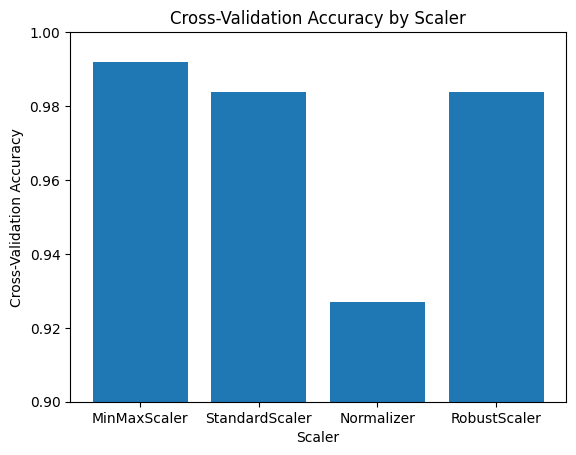

In [22]:
wine_graph.cross_validation_score(0.9, 1.0)

#### Best Parameters

MinMaxScaler	             10
StandardScaler	            100
Normalizer  	            100
RobustScaler	             10


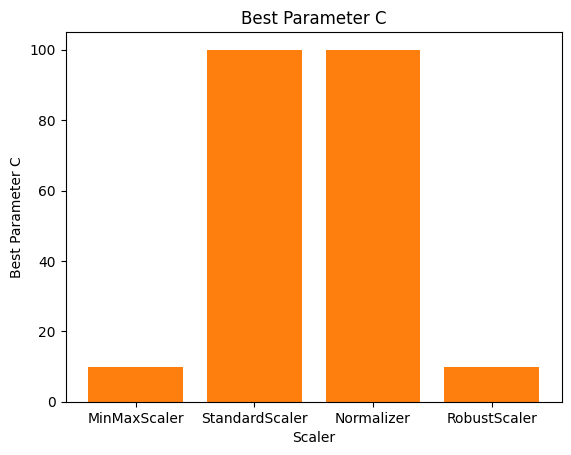

In [23]:
wine_graph.best_parameter_C()

MinMaxScaler	            0.1
StandardScaler	          0.001
Normalizer  	            100
RobustScaler	           0.01


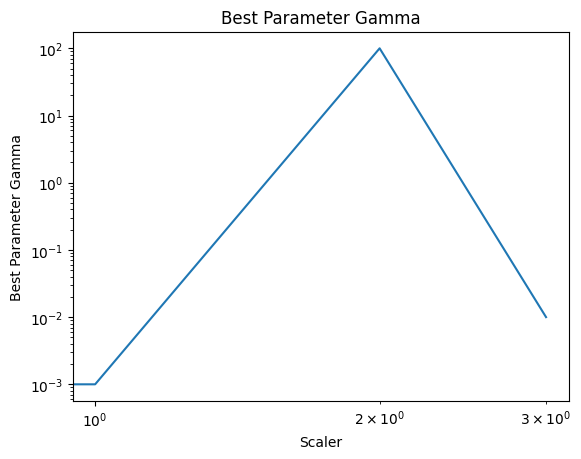

In [24]:
wine_graph.best_parameter_gamma()

#### Test Set Score

MinMaxScaler        	 0.008130081300813052
StandardScaler      	 0.01606658923732096
Normalizer          	   0.072977158343012
RobustScaler        	 0.016260162601625994


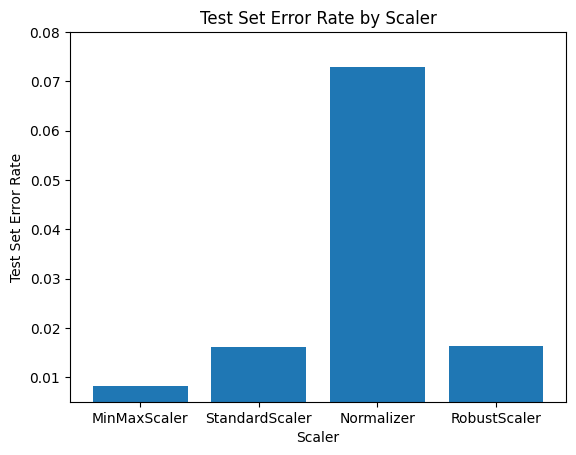

In [25]:
wine_graph.test_score(0.005, 0.08)

## USPS Dataset

### MinMax Scaler

In [26]:
zip_svm_super_pipe_minmax: Super_Pipeline = Super_Pipeline(param_grid_svm, MinMaxScaler, X_zip_train, y_zip_train, X_zip_test, y_zip_test, SVC())
print(zip_svm_super_pipe_minmax)

Best Cross-Validation Score	 0.7373737373737373                  
Best Parameters            	 {'svc__C': 100, 'svc__gamma': 0.001}
Test Set Score             	 0.5862068965517241                  
Test Set Error Rate        	 0.26262626262626265                 


### Standard Scaler

In [27]:
zip_svm_super_pipe_standard: Super_Pipeline = Super_Pipeline(param_grid_svm, StandardScaler, X_zip_train, y_zip_train, X_zip_test, y_zip_test, SVC())
print(zip_svm_super_pipe_standard)

Best Cross-Validation Score	 0.7070707070707071                 
Best Parameters            	 {'svc__C': 10, 'svc__gamma': 0.001}
Test Set Score             	 0.5517241379310345                 
Test Set Error Rate        	 0.29292929292929293                


### Normalizer

In [28]:
zip_svm_super_pipe_robust: Super_Pipeline = Super_Pipeline(param_grid_svm, RobustScaler, X_zip_train, y_zip_train, X_zip_test, y_zip_test, SVC())
print(zip_svm_super_pipe_robust)

Best Cross-Validation Score	 0.4437229437229437                  
Best Parameters            	 {'svc__C': 100, 'svc__gamma': 0.001}
Test Set Score             	 0.5862068965517241                  
Test Set Error Rate        	 0.5562770562770563                  


### Robust Scaler

In [29]:
zip_svm_super_pipe_normalizer: Super_Pipeline = Super_Pipeline(param_grid_svm, Normalizer, X_zip_train, y_zip_train, X_zip_test, y_zip_test, SVC())
print(zip_svm_super_pipe_normalizer)

Best Cross-Validation Score	 0.7532467532467533                
Best Parameters            	 {'svc__C': 100, 'svc__gamma': 0.1}
Test Set Score             	 0.5862068965517241                
Test Set Error Rate        	 0.24675324675324672               


### Comparison

In [30]:
zip_super_pipes: dict[str, Super_Pipeline] = {
	"MinMaxScaler": zip_svm_super_pipe_minmax,
	"StandardScaler": zip_svm_super_pipe_standard,
	"Normalizer": zip_svm_super_pipe_normalizer,
	"RobustScaler": zip_svm_super_pipe_robust
}

zip_graph: Graph_Comparisons = Graph_Comparisons(zip_super_pipes, param_grid_svm)

#### Best Cross-Validation Score

MinMaxScaler      	 0.7373737373737373
StandardScaler    	 0.7070707070707071
Normalizer        	 0.7532467532467533
RobustScaler      	 0.4437229437229437


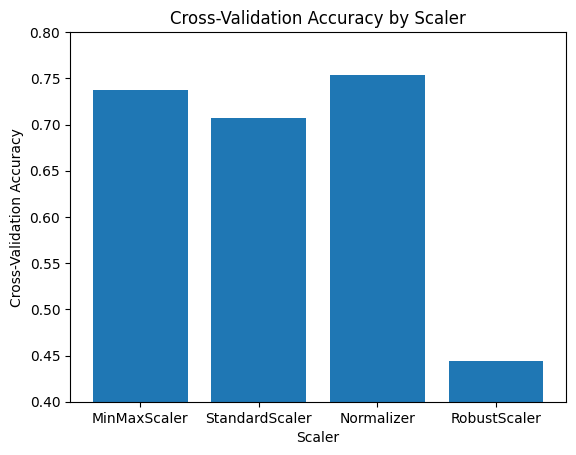

In [31]:
zip_graph.cross_validation_score(0.4, 0.8)

#### Best Parameters

MinMaxScaler	            100
StandardScaler	             10
Normalizer  	            100
RobustScaler	            100


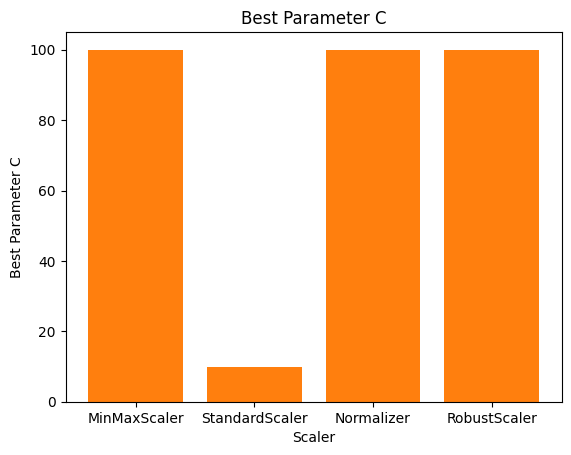

In [32]:
zip_graph.best_parameter_C()

MinMaxScaler	          0.001
StandardScaler	          0.001
Normalizer  	            0.1
RobustScaler	          0.001


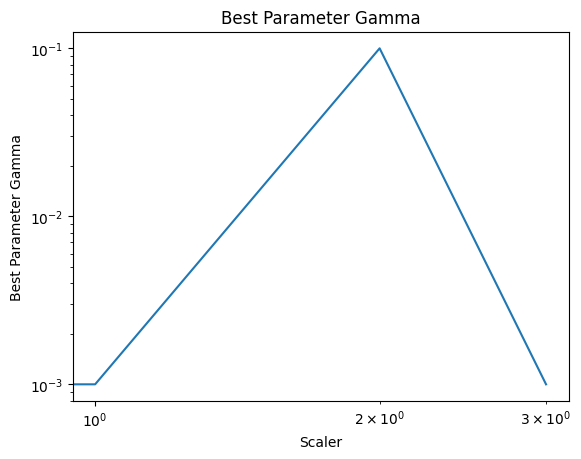

In [33]:
zip_graph.best_parameter_gamma()

#### Test Set Score

MinMaxScaler       	 0.26262626262626265
StandardScaler     	 0.29292929292929293
Normalizer         	 0.24675324675324672
RobustScaler       	  0.5562770562770563


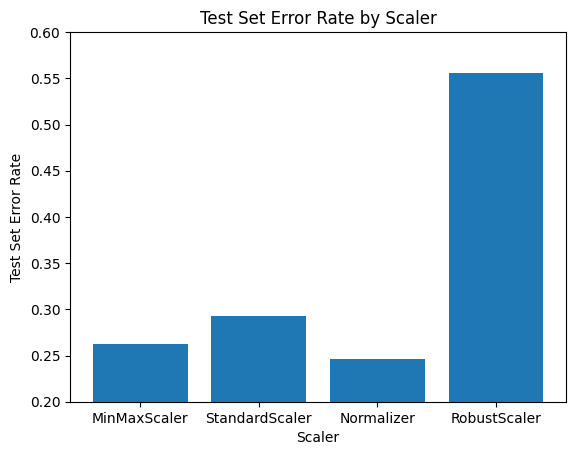

In [34]:
zip_graph.test_score(0.2, 0.6)

# Neural Network

**Question 8**

## Cross-Validation

### Wine Dataset

In [35]:
wine_mlp_cross_validation: Cross_Validation = Cross_Validation(X_wine_train, y_wine_train, X_wine_test, y_wine_test, MLPClassifier(random_state=RANDOM_STATE))

In [36]:
print(wine_mlp_cross_validation)

Score              	 0.27409988385598144
Error Rate         	 0.7259001161440186
Test Score         	 0.25925925925925924
Test Error Rate    	 0.7407407407407407


In [37]:
print(wine_svm_cross_validation)

Score             	 0.6533101045296168
Error Rate        	 0.3466898954703832
Test Score        	 0.7222222222222222
Test Error Rate   	 0.2777777777777778


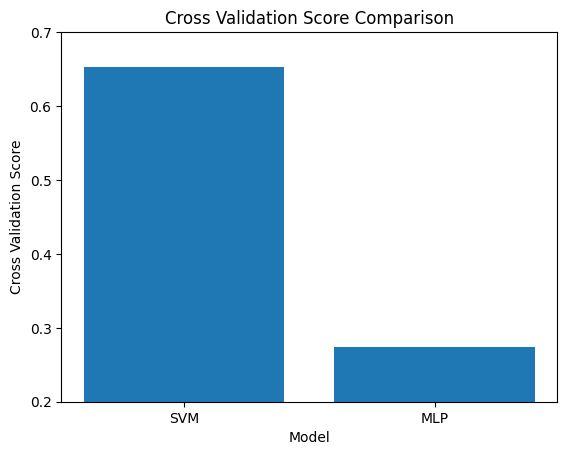

In [38]:
# plot a graph comparing the cross validation scores of the two models
plt.bar(["SVM", "MLP"], [wine_svm_cross_validation.score, wine_mlp_cross_validation.score])
plt.title("Cross Validation Score Comparison")
plt.ylabel("Cross Validation Score")
plt.xlabel("Model")
plt.ylim(0.2, 0.7)
plt.show()

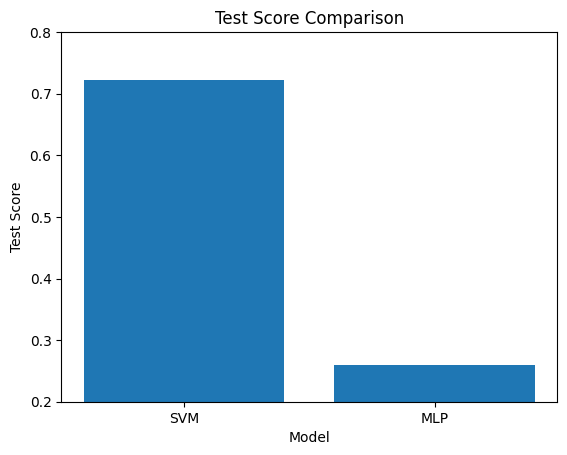

In [39]:
# plot a graph comparing the test scores of the two models
plt.bar(["SVM", "MLP"], [wine_svm_cross_validation.test_score, wine_mlp_cross_validation.test_score])
plt.title("Test Score Comparison")
plt.ylabel("Test Score")
plt.xlabel("Model")
plt.ylim(0.2, 0.8)
plt.show()

### Zip Dataset

In [40]:
zip_mlp_cross_validation: Cross_Validation = Cross_Validation(X_zip_train, y_zip_train, X_zip_test, y_zip_test, MLPClassifier(random_state=RANDOM_STATE))

In [41]:
print(zip_mlp_cross_validation)

Score             	 0.7056277056277057
Error Rate        	 0.2943722943722943
Test Score        	 0.5517241379310345
Test Error Rate   	 0.4482758620689655


In [42]:
print(zip_mlp_cross_validation)

Score             	 0.7056277056277057
Error Rate        	 0.2943722943722943
Test Score        	 0.5517241379310345
Test Error Rate   	 0.4482758620689655


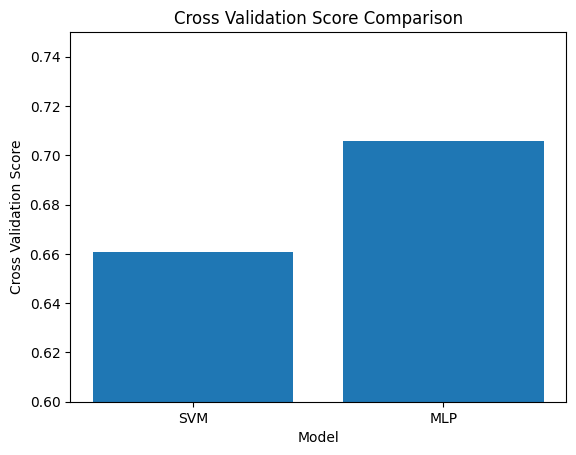

In [43]:
plt.bar(["SVM", "MLP"], [zip_svm_cross_validation.score, zip_mlp_cross_validation.score])
plt.title("Cross Validation Score Comparison")
plt.ylabel("Cross Validation Score")
plt.xlabel("Model")
plt.ylim(0.6, 0.75)
plt.show()

## Comparing Scalers

In [44]:
param_grid_mlp: dict[str, list[float]] = {
	'mlpclassifier__solver': ['adam', 'lbfgs', 'sgd'],
	'mlpclassifier__hidden_layer_sizes': [[10],[10,10],[10,10,10]],
	'mlpclassifier__activation': ['tanh', 'relu'],
}

### Wine Dataset

#### MinMax Scaler

In [45]:
wine_mlp_super_pipe_minmax: Super_Pipeline = Super_Pipeline(param_grid_mlp, MinMaxScaler, X_wine_train, y_wine_train, X_wine_test, y_wine_test, MLPClassifier(random_state=RANDOM_STATE))

/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:

In [46]:
print(wine_mlp_super_pipe_minmax)

Best Cross-Validation Score	 0.9758033294618661                                                                                                
Best Parameters            	 {'mlpclassifier__activation': 'tanh', 'mlpclassifier__hidden_layer_sizes': [10], 'mlpclassifier__solver': 'lbfgs'}
Test Set Score             	 0.9814814814814815                                                                                                
Test Set Error Rate        	 0.024196670538133902                                                                                              


#### Standard Scaler

In [47]:
wine_mlp_super_pipe_standard: Super_Pipeline = Super_Pipeline(param_grid_mlp, StandardScaler, X_wine_train, y_wine_train, X_wine_test, y_wine_test, MLPClassifier(random_state=RANDOM_STATE))

/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:

In [48]:
print(wine_mlp_super_pipe_standard)

Best Cross-Validation Score	 0.991869918699187                                                                                                         
Best Parameters            	 {'mlpclassifier__activation': 'tanh', 'mlpclassifier__hidden_layer_sizes': [10, 10, 10], 'mlpclassifier__solver': 'lbfgs'}
Test Set Score             	 0.9814814814814815                                                                                                        
Test Set Error Rate        	 0.008130081300813052                                                                                                      


#### Normalizer

In [49]:
wine_mlp_super_pipe_normalizer: Super_Pipeline = Super_Pipeline(param_grid_mlp, Normalizer, X_wine_train, y_wine_train, X_wine_test, y_wine_test, MLPClassifier(random_state=RANDOM_STATE))

/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:

In [50]:
print(wine_mlp_super_pipe_normalizer)

Best Cross-Validation Score	 0.800038714672861                                                                                                 
Best Parameters            	 {'mlpclassifier__activation': 'tanh', 'mlpclassifier__hidden_layer_sizes': [10], 'mlpclassifier__solver': 'lbfgs'}
Test Set Score             	 0.9814814814814815                                                                                                
Test Set Error Rate        	 0.19996128532713897                                                                                               


#### Robust Scaler

In [51]:
wine_mlp_super_pipe_robust: Super_Pipeline = Super_Pipeline(param_grid_mlp, RobustScaler, X_wine_train, y_wine_train, X_wine_test, y_wine_test, MLPClassifier(random_state=RANDOM_STATE))

/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:

In [52]:
print(wine_mlp_super_pipe_robust)

Best Cross-Validation Score	 0.9841269841269842                                                                                                    
Best Parameters            	 {'mlpclassifier__activation': 'tanh', 'mlpclassifier__hidden_layer_sizes': [10, 10], 'mlpclassifier__solver': 'lbfgs'}
Test Set Score             	 0.9814814814814815                                                                                                    
Test Set Error Rate        	 0.015873015873015817                                                                                                  


#### Comparison

In [53]:
wine_super_pipes_mlp: dict[str, Super_Pipeline] = {
	"MinMaxScaler": wine_mlp_super_pipe_minmax,
	"StandardScaler": wine_mlp_super_pipe_standard,
	"Normalizer": wine_mlp_super_pipe_normalizer,
	"RobustScaler": wine_mlp_super_pipe_robust
}
wine_graph_mlp: Graph_Comparisons = Graph_Comparisons(wine_super_pipes_mlp, param_grid_mlp)

##### Best Cross Validation Score

MinMaxScaler      	 0.9758033294618661
StandardScaler    	 0.991869918699187
Normalizer        	 0.800038714672861
RobustScaler      	 0.9841269841269842


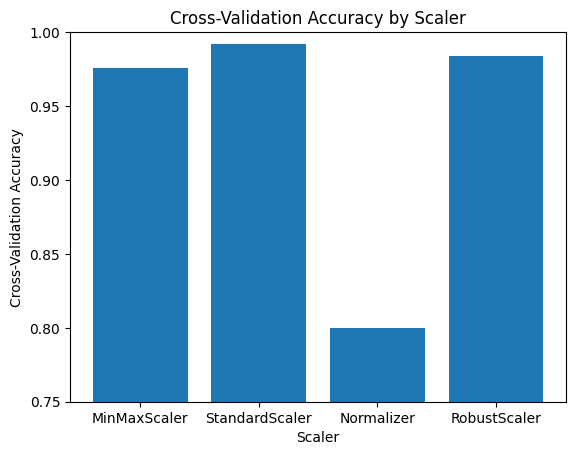

In [54]:
wine_graph_mlp.cross_validation_score(0.75, 1)

##### Test Score

MinMaxScaler        	 0.024196670538133902
StandardScaler      	 0.008130081300813052
Normalizer          	  0.19996128532713897
RobustScaler        	 0.015873015873015817


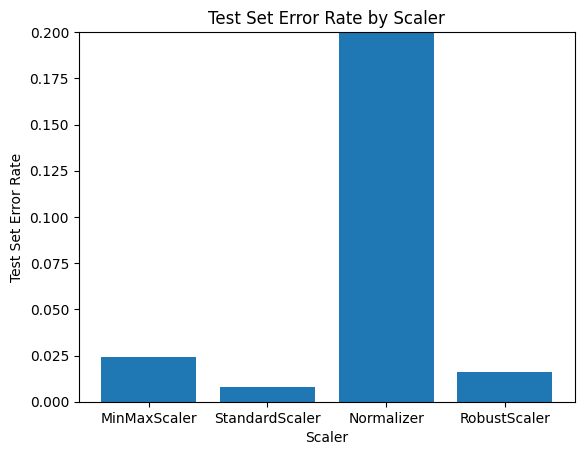

In [55]:
wine_graph_mlp.test_score(0, 0.2)

### Zip Dataset

#### MinMax Scaler

In [56]:
zip_mlp_super_pipe_minmax: Super_Pipeline = Super_Pipeline(param_grid_mlp, MinMaxScaler, X_zip_train, y_zip_train, X_zip_test, y_zip_test, MLPClassifier(random_state=RANDOM_STATE))

/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:

In [57]:
print(zip_mlp_super_pipe_minmax)

Best Cross-Validation Score	 0.7669552669552671                                                                                                
Best Parameters            	 {'mlpclassifier__activation': 'tanh', 'mlpclassifier__hidden_layer_sizes': [10], 'mlpclassifier__solver': 'lbfgs'}
Test Set Score             	 0.5862068965517241                                                                                                
Test Set Error Rate        	 0.23304473304473294                                                                                               


#### Standard Scaler

In [58]:
zip_mlp_super_pipe_standard: Super_Pipeline = Super_Pipeline(param_grid_mlp, StandardScaler, X_zip_train, y_zip_train, X_zip_test, y_zip_test, MLPClassifier(random_state=RANDOM_STATE))

/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:

In [59]:
print(zip_mlp_super_pipe_standard)

Best Cross-Validation Score	 0.7676767676767677                                                                                                
Best Parameters            	 {'mlpclassifier__activation': 'relu', 'mlpclassifier__hidden_layer_sizes': [10], 'mlpclassifier__solver': 'lbfgs'}
Test Set Score             	 0.5862068965517241                                                                                                
Test Set Error Rate        	 0.23232323232323226                                                                                               


#### Normalizer

In [60]:
zip_mlp_super_pipe_normalizer: Super_Pipeline = Super_Pipeline(param_grid_mlp, Normalizer, X_zip_train, y_zip_train, X_zip_test, y_zip_test, MLPClassifier(random_state=RANDOM_STATE))

/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:

In [61]:
print(zip_mlp_super_pipe_normalizer)

Best Cross-Validation Score	 0.797979797979798                                                                                                 
Best Parameters            	 {'mlpclassifier__activation': 'tanh', 'mlpclassifier__hidden_layer_sizes': [10], 'mlpclassifier__solver': 'lbfgs'}
Test Set Score             	 0.5517241379310345                                                                                                
Test Set Error Rate        	 0.202020202020202                                                                                                 


#### Robust Scaler

In [62]:
zip_mlp_super_pipe_robust: Super_Pipeline = Super_Pipeline(param_grid_mlp, RobustScaler, X_zip_train, y_zip_train, X_zip_test, y_zip_test, MLPClassifier(random_state=RANDOM_STATE))

/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maruf/.cache/pypoetry/virtualenvs/anaconda-pOKeClin-py3.11/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:

In [63]:
print(zip_mlp_super_pipe_robust)

Best Cross-Validation Score	 0.5699855699855699                                                                                                       
Best Parameters            	 {'mlpclassifier__activation': 'tanh', 'mlpclassifier__hidden_layer_sizes': [10, 10, 10], 'mlpclassifier__solver': 'adam'}
Test Set Score             	 0.4827586206896552                                                                                                       
Test Set Error Rate        	 0.43001443001443007                                                                                                      


#### Comparison

In [64]:
zip_super_pipes_mlp: dict[str, Super_Pipeline] = {
	"MinMaxScaler": zip_mlp_super_pipe_minmax,
	"StandardScaler": zip_mlp_super_pipe_standard,
	"Normalizer": zip_mlp_super_pipe_normalizer,
	"RobustScaler": zip_mlp_super_pipe_robust
}
zip_graph_mlp: Graph_Comparisons = Graph_Comparisons(zip_super_pipes_mlp, param_grid_mlp)

##### Best Cross Validation Score

MinMaxScaler      	 0.7669552669552671
StandardScaler    	 0.7676767676767677
Normalizer        	  0.797979797979798
RobustScaler      	 0.5699855699855699


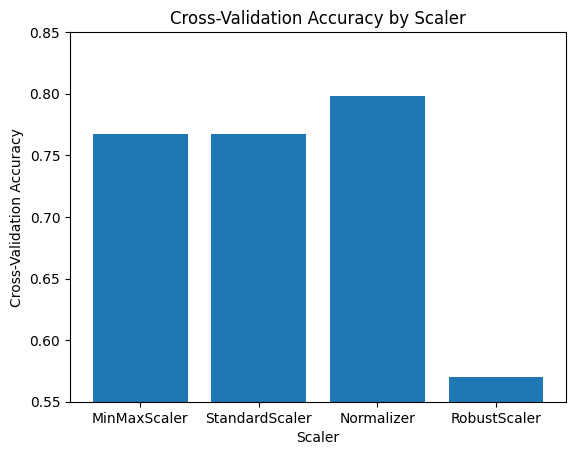

In [67]:
zip_graph_mlp.cross_validation_score(0.55, 0.85)

# Conformal Prediction

In [65]:
kf: KFold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cpp: GridSearchCV